In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Работа с air_reserve. Буду определять что за датасет, количество ненулевых и уникальных значений

Общий план: импортирую датафреймы для air, привожу их к дням, где надо и потом объединяю. Чищу от аномалий, думаю над пропусками и тд

In [117]:
df_air_reserve = pd.read_csv('recruit-restaurant-visitor-forecasting/air_reserve.csv')
df_air_store_info = pd.read_csv('recruit-restaurant-visitor-forecasting/air_store_info.csv')
df_visit_data = pd.read_csv('recruit-restaurant-visitor-forecasting/air_visit_data.csv')
hpg_df = pd.read_csv('recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
store_id_relation = pd.read_csv('recruit-restaurant-visitor-forecasting/store_id_relation.csv')
hpg_store = pd.read_csv('recruit-restaurant-visitor-forecasting/hpg_store_info.csv')
date_df = pd.read_csv('recruit-restaurant-visitor-forecasting/date_info.csv')

In [118]:
store_id_relation.shape


(150, 2)

In [119]:
print(date_df.shape)
date_df

(517, 3)


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [120]:
store_id_relation.isnull().sum()

air_store_id    0
hpg_store_id    0
dtype: int64

In [121]:
df_air_reserve.head(10)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
5,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 16:00:00,2
6,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 15:00:00,4
7,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-02 14:00:00,2
8,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-01 20:00:00,2
9,air_2b8b29ddfd35018e,2016-01-02 17:00:00,2016-01-02 17:00:00,2


Для начала рассмотрим зависимость количества людей по дням, для этого сложу в первом даатафрейме количество зарезервировавшихся пользователей по дням

In [122]:
df_air_reserve['visit_datetime'] = pd.to_datetime(df_air_reserve['visit_datetime'])
df_air_reserve['reserve_datetime'] = pd.to_datetime(df_air_reserve['reserve_datetime'])
df_air_reserve['reserve_date'] = df_air_reserve['reserve_datetime'].dt.date
df_air_reserve['visit_date'] = df_air_reserve['visit_datetime'].dt.date

In [123]:
df_air_reserve = df_air_reserve.groupby(['air_store_id', 'visit_date', 'reserve_date'])['reserve_visitors'].sum().reset_index()

In [124]:
air_df = pd.merge(df_air_reserve, df_air_store_info, on='air_store_id', how='outer')

In [125]:
air_df = pd.merge(air_df, df_visit_data, on=['air_store_id', 'visit_date'], how='outer')

In [126]:
air_df = pd.merge(air_df, store_id_relation, on=['air_store_id'], how='outer')

In [127]:
air_df=air_df[['air_store_id','hpg_store_id', 'visit_date','visitors', 'reserve_visitors', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']]

In [128]:
air_df = air_df.rename(columns={'air_genre_name':'genre_name', 'air_area_name':'area_name'})


Так как данные с пустым столбцом посетителей нам не нужны (это целевая переменная) удаляем их

In [129]:
air_df.dropna(subset='visitors', inplace=True)
air_df['visitors'] = air_df['visitors'].astype(int)

In [130]:
air_df.shape

(252108, 9)

С первой системой данных выполнил объединение

In [131]:
hpg_df['visit_datetime'] = pd.to_datetime(hpg_df['visit_datetime'])
hpg_df['reserve_datetime'] = pd.to_datetime(hpg_df['reserve_datetime'])
hpg_df['reserve_date'] = hpg_df['reserve_datetime'].dt.date
hpg_df['visit_date'] = hpg_df['visit_datetime'].dt.date

In [132]:
hpg_df = hpg_df.groupby(['hpg_store_id', 'visit_date', 'reserve_date'])[
    'reserve_visitors'].sum().reset_index()

In [133]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [134]:
hpg_df = pd.merge(store_id_relation, hpg_df, on='hpg_store_id', how='outer')


In [135]:
hpg_df = pd.merge(hpg_df, hpg_store, on='hpg_store_id', how='outer')

In [136]:
hpg_df=hpg_df[['air_store_id','hpg_store_id', 'visit_date', 'reserve_visitors', 'hpg_genre_name', 'hpg_area_name', 'latitude', 'longitude']]

In [137]:
hpg_df = hpg_df.rename(columns={'hpg_genre_name':'genre_name', 'hpg_area_name':'area_name'})

Объединил данные для второй системы


In [138]:
print(air_df.shape)
air_df.isnull().sum()

(252108, 9)


air_store_id             0
hpg_store_id        206089
visit_date               0
visitors                 0
reserve_visitors    252108
genre_name          252108
area_name           252108
latitude            252108
longitude           252108
dtype: int64

In [139]:
print(hpg_df.shape)
hpg_df.isnull().sum()

(1879302, 8)


air_store_id        1852770
hpg_store_id              0
visit_date                0
reserve_visitors          0
genre_name          1065690
area_name           1065690
latitude            1065690
longitude           1065690
dtype: int64

In [140]:
print(air_df.air_store_id.nunique(), hpg_df.air_store_id.nunique(), air_df.hpg_store_id.nunique(), hpg_df.hpg_store_id.nunique())

829 150 150 13325


In [141]:
df = pd.merge(air_df, hpg_df, on=['air_store_id', 'hpg_store_id','visit_date' , 'reserve_visitors', 'area_name', 'genre_name', 'latitude', 'longitude'], how='outer')

In [142]:
df

,air_store_id,hpg_store_id,visit_date,visitors,reserve_visitors,genre_name,area_name,latitude,longitude
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-14,NaN,2.0,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-15,NaN,4.0,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-16,NaN,2.0,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-22,NaN,2.0,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-29,NaN,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2131405,NaN,hpg_fffc097dce87af3e,2017-03-10,NaN,2.0,NaN,NaN,NaN,NaN
2131406,NaN,hpg_fffc097dce87af3e,2017-03-17,NaN,2.0,NaN,NaN,NaN,NaN
2131407,NaN,hpg_fffc097dce87af3e,2017-03-27,NaN,5.0,NaN,NaN,NaN,NaN
2131408,NaN,hpg_fffc097dce87af3e,2017-04-21,NaN,3.0,NaN,NaN,NaN,NaN


In [143]:
print(df.shape)
df.isnull().sum()

(2131410, 9)


air_store_id        1852770
hpg_store_id         206089
visit_date                0
visitors            1879302
reserve_visitors     252108
genre_name          1317798
area_name           1317798
latitude            1317798
longitude           1317798
dtype: int64

Проверил данные по месяцам для тренировочной выборки, сейчас буду делать dataframe для столбцов с заполненной целевой переменной и буду дополнять его данными из други строк согласовано 

In [144]:
print(df.visit_date.unique)
df.columns

<bound method Series.unique of 0          2016-01-14
1          2016-01-15
2          2016-01-16
3          2016-01-22
4          2016-01-29
              ...    
2131405    2017-03-10
2131406    2017-03-17
2131407    2017-03-27
2131408    2017-04-21
2131409    2017-04-23
Name: visit_date, Length: 2131410, dtype: object>


Index(['air_store_id', 'hpg_store_id', 'visit_date', 'visitors',
       'reserve_visitors', 'genre_name', 'area_name', 'latitude', 'longitude'],
      dtype='object')

In [145]:
df_full = df.dropna(subset=['visitors'])
print(df_full.shape)
df_full

(252108, 9)


,air_store_id,hpg_store_id,visit_date,visitors,reserve_visitors,genre_name,area_name,latitude,longitude
111,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-01,35.0,NaN,NaN,NaN,NaN,NaN
112,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-02,9.0,NaN,NaN,NaN,NaN,NaN
113,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-04,20.0,NaN,NaN,NaN,NaN,NaN
114,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-05,25.0,NaN,NaN,NaN,NaN,NaN
115,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-07-06,29.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
278635,air_fff68b929994bfbd,NaN,2017-04-18,6.0,NaN,NaN,NaN,NaN,NaN
278636,air_fff68b929994bfbd,NaN,2017-04-19,2.0,NaN,NaN,NaN,NaN,NaN
278637,air_fff68b929994bfbd,NaN,2017-04-20,2.0,NaN,NaN,NaN,NaN,NaN
278638,air_fff68b929994bfbd,NaN,2017-04-21,4.0,NaN,NaN,NaN,NaN,NaN


In [146]:
df_missing = df[df['visitors'].isna()]
print(df_missing.shape)
df_missing

(1879302, 9)


,air_store_id,hpg_store_id,visit_date,visitors,reserve_visitors,genre_name,area_name,latitude,longitude
0,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-14,NaN,2.0,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-15,NaN,4.0,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-16,NaN,2.0,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-22,NaN,2.0,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9,hpg_fbe603376b5980fc,2016-01-29,NaN,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2131405,NaN,hpg_fffc097dce87af3e,2017-03-10,NaN,2.0,NaN,NaN,NaN,NaN
2131406,NaN,hpg_fffc097dce87af3e,2017-03-17,NaN,2.0,NaN,NaN,NaN,NaN
2131407,NaN,hpg_fffc097dce87af3e,2017-03-27,NaN,5.0,NaN,NaN,NaN,NaN
2131408,NaN,hpg_fffc097dce87af3e,2017-04-21,NaN,3.0,NaN,NaN,NaN,NaN


In [147]:
df_result_air = df_full.set_index(['air_store_id', 'visit_date']).combine_first(
    df_missing.set_index(['air_store_id', 'visit_date'])
).reset_index()
# Объединяем по hpg_store_id и visit_date
df_result_hpg = df_full.set_index(['hpg_store_id', 'visit_date']).combine_first(
    df_missing.set_index(['hpg_store_id', 'visit_date'])
).reset_index()

# Объединяем результаты двух объединений
df_result = pd.concat([df_result_air, df_result_hpg]).drop_duplicates()

# Оставляем только строки с заполненным visitors
df_result = df_result[df_result['visitors'].notna()]

# Удаляем дубликаты, если они есть
df_result = df_result.drop_duplicates()
print(df_result.shape)
df=df_result
df['visitors'] = df['visitors'].astype(int)
df

(252108, 9)


,air_store_id,visit_date,hpg_store_id,visitors,reserve_visitors,genre_name,area_name,latitude,longitude
111,air_00a91d42b08b08d9,2016-07-01,hpg_fbe603376b5980fc,35,NaN,NaN,NaN,NaN,NaN
112,air_00a91d42b08b08d9,2016-07-02,hpg_fbe603376b5980fc,9,NaN,NaN,NaN,NaN,NaN
113,air_00a91d42b08b08d9,2016-07-04,hpg_fbe603376b5980fc,20,NaN,NaN,NaN,NaN,NaN
114,air_00a91d42b08b08d9,2016-07-05,hpg_fbe603376b5980fc,25,NaN,NaN,NaN,NaN,NaN
115,air_00a91d42b08b08d9,2016-07-06,hpg_fbe603376b5980fc,29,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
278635,air_fff68b929994bfbd,2017-04-18,NaN,6,NaN,NaN,NaN,NaN,NaN
278636,air_fff68b929994bfbd,2017-04-19,NaN,2,NaN,NaN,NaN,NaN,NaN
278637,air_fff68b929994bfbd,2017-04-20,NaN,2,NaN,NaN,NaN,NaN,NaN
278638,air_fff68b929994bfbd,2017-04-21,NaN,4,NaN,NaN,NaN,NaN,NaN


вот я объединил это хорошо, но теперь надо выбрать вариант: 
1.  Объединить датасеты 
2. Дополнить датасет air

 Я иду по второму пути, потому что у air есть данные о посетителях, а у второго нет. Но надо по максимуму дополнить по остальным данным и это сделаю из второго датасета. Потом опять удалю все, что без значения количества посетителей и проверю аномальные значения.
 
я уже выше сделал это, теперь надо именно подготовить данные к анализу: удалить аномалии и тд



In [149]:
date_df = date_df.rename(columns={'calendar_date':'visit_date'})

In [150]:
date_df 

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [151]:
df = pd.merge(df, date_df, on='visit_date', how='outer')
print(df.shape)

(252147, 11)


In [153]:
df = df.dropna(subset=['visitors'])
print(df.shape)

(252108, 11)


In [154]:
df

,air_store_id,visit_date,hpg_store_id,visitors,reserve_visitors,genre_name,area_name,latitude,longitude,day_of_week,holiday_flg
0,air_04341b588bde96cd,2016-01-01,NaN,10.0,NaN,NaN,NaN,NaN,NaN,Friday,1
1,air_05c325d315cc17f5,2016-01-01,NaN,29.0,NaN,NaN,NaN,NaN,NaN,Friday,1
2,air_08ba8cd01b3ba010,2016-01-01,NaN,11.0,NaN,NaN,NaN,NaN,NaN,Friday,1
3,air_09a845d5b5944b01,2016-01-01,NaN,56.0,NaN,NaN,NaN,NaN,NaN,Friday,1
4,air_1f7f8fa557bc0d55,2016-01-01,NaN,6.0,NaN,NaN,NaN,NaN,NaN,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...
252103,air_fea5dc9594450608,2017-04-22,hpg_6507818140022452,14.0,NaN,NaN,NaN,NaN,NaN,Saturday,0
252104,air_fee8dcf4d619598e,2017-04-22,NaN,53.0,NaN,NaN,NaN,NaN,NaN,Saturday,0
252105,air_fef9ccb3ba0da2f7,2017-04-22,NaN,5.0,NaN,NaN,NaN,NaN,NaN,Saturday,0
252106,air_ffcc2d5087e1b476,2017-04-22,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Saturday,0


Добавил столбец с днями недели и праздниками. Начинаю обработку

In [155]:
df.air_store_id.unique()

array(['air_04341b588bde96cd', 'air_05c325d315cc17f5',
       'air_08ba8cd01b3ba010', 'air_09a845d5b5944b01',
       'air_1f7f8fa557bc0d55', 'air_2570ccb93badde68',
       'air_25d8e5cc57dd87d9', 'air_298513175efdf261',
       'air_35c4732dcbfe31be', 'air_36bcf77d3382d36e',
       'air_39dccf7df20b1c6a', 'air_3b6438b125086430',
       'air_506fe758114df773', 'air_536043fcf1a4f8a4',
       'air_57ed725a1930a5b9', 'air_5b6d18c470bbfaf9',
       'air_5c65468938c07fa5', 'air_60a7057184ec7ec7',
       'air_6e3fd96320d24324', 'air_70e9e8cd55879414',
       'air_71903025d39a4571', 'air_79f528087f49df06',
       'air_7cc17a324ae5c7dc', 'air_81c5dff692063446',
       'air_877f79706adbfb06', 'air_87f9e1024b951f01',
       'air_883ca28ef0ed3d55', 'air_8d50c64692322dff',
       'air_9d452a881f7f2bb7', 'air_a083834e7ffe187e',
       'air_b2d8bc9c88b85f96', 'air_c31472d14e29cee8',
       'air_c92745dfdd2ec68a', 'air_cb7467aed805e7fe',
       'air_cfdeb326418194ff', 'air_d0a1e69685259c92',
       'ai

In [156]:
df.air_store_id.nunique()

829

In [ ]:
plt.figure(figsize=(12, 8))
colums = df.corr().columns.tolist()
plt.imshow(df.corr())

plt.title('')

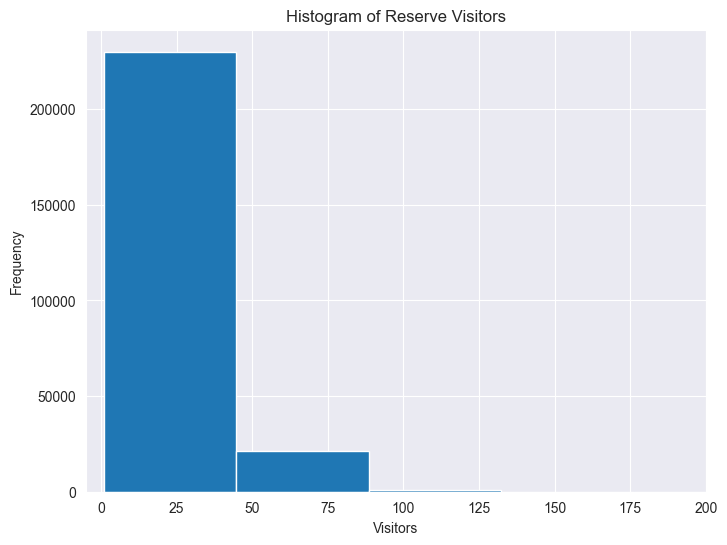

In [41]:
plt.figure(figsize=(8,6))
plt.hist(df['visitors'], bins=20)
plt.xlim(-5, 200)
plt.xlabel('Visitors')
plt.ylabel('Frequency')
plt.title('Histogram of Reserve Visitors')
plt.show()

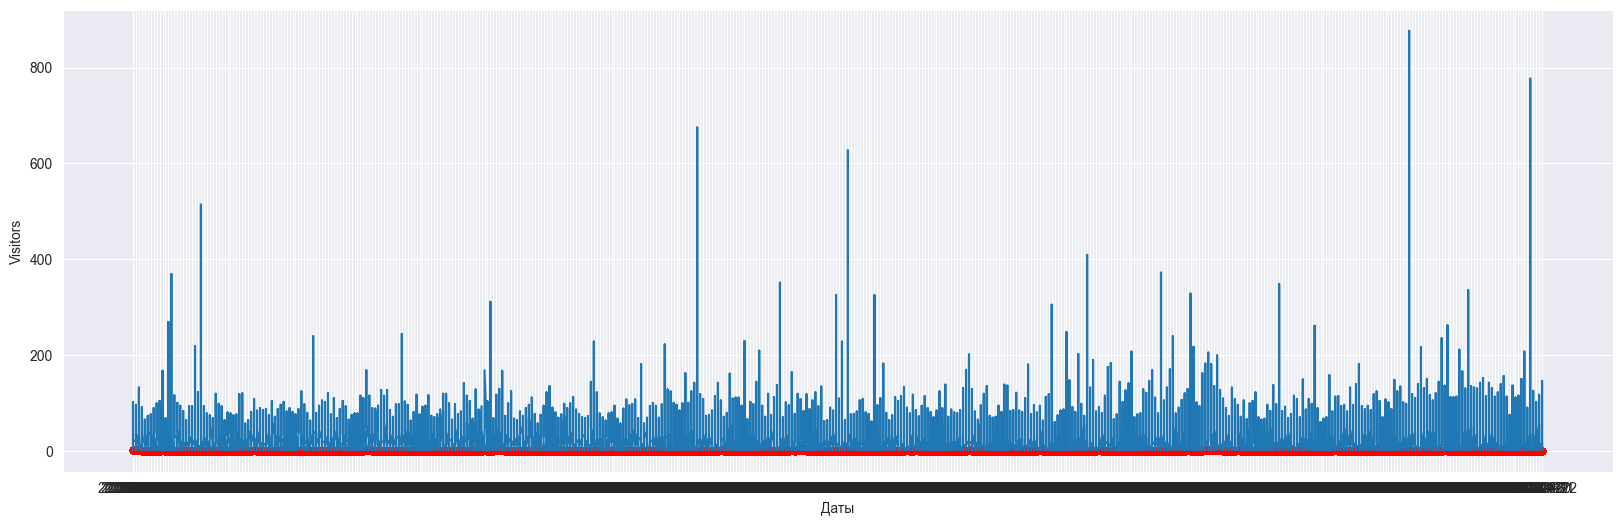

Text(0.5, 1.0, 'Ящик с усами для количества забронированных пользователей (с аномалиями)')

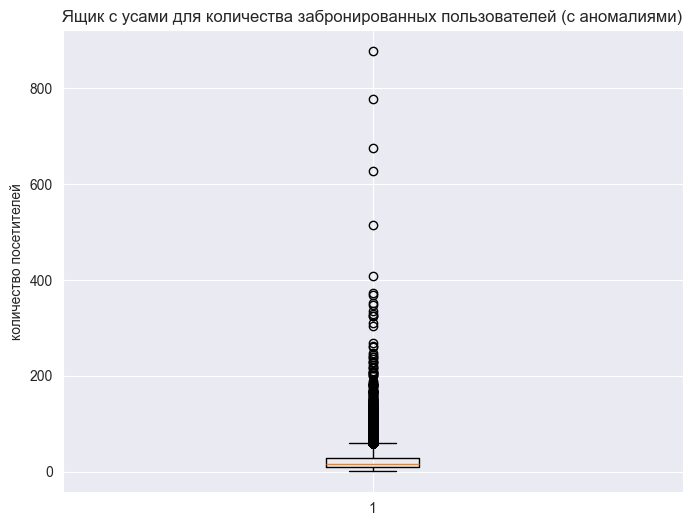

In [385]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(df['visitors'])
ax.set_ylabel('количество посетителей')
ax.set_title('Ящик с усами для количества забронированных пользователей (с аномалиями)')


In [387]:
df.info

<bound method DataFrame.info of                 air_store_id  visit_date          hpg_store_id  visitors  \
123     air_00a91d42b08b08d9  2016-07-01  hpg_fbe603376b5980fc        35   
124     air_00a91d42b08b08d9  2016-07-02  hpg_fbe603376b5980fc         9   
125     air_00a91d42b08b08d9  2016-07-04  hpg_fbe603376b5980fc        20   
126     air_00a91d42b08b08d9  2016-07-05  hpg_fbe603376b5980fc        25   
127     air_00a91d42b08b08d9  2016-07-06  hpg_fbe603376b5980fc        29   
...                      ...         ...                   ...       ...   
346569  air_fff68b929994bfbd  2017-04-18                   NaN         6   
346570  air_fff68b929994bfbd  2017-04-19                   NaN         2   
346571  air_fff68b929994bfbd  2017-04-20                   NaN         2   
346572  air_fff68b929994bfbd  2017-04-21                   NaN         4   
346573  air_fff68b929994bfbd  2017-04-22                   NaN         5   

        reserve_visitors genre_name area_name  latitude

In [388]:
df.describe()

,visitors,reserve_visitors,latitude,longitude
count,252108.000000,0.0,0.0,0.0
mean,20.973761,NaN,NaN,NaN
std,16.757007,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,9.000000,NaN,NaN,NaN
50%,17.000000,NaN,NaN,NaN
75%,29.000000,NaN,NaN,NaN
max,877.000000,NaN,NaN,NaN


In [395]:
print(df.shape, df.air_store_id.notna().sum(), df.hpg_store_id.notna().sum(), df.air_store_id.nunique(), df.hpg_store_id.nunique())

(252108, 9) 252108 46019 829 150


In [397]:
del df['hpg_store_id']

In [398]:
df

,air_store_id,visit_date,visitors,reserve_visitors,genre_name,area_name,latitude,longitude
123,air_00a91d42b08b08d9,2016-07-01,35,NaN,NaN,NaN,NaN,NaN
124,air_00a91d42b08b08d9,2016-07-02,9,NaN,NaN,NaN,NaN,NaN
125,air_00a91d42b08b08d9,2016-07-04,20,NaN,NaN,NaN,NaN,NaN
126,air_00a91d42b08b08d9,2016-07-05,25,NaN,NaN,NaN,NaN,NaN
127,air_00a91d42b08b08d9,2016-07-06,29,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
346569,air_fff68b929994bfbd,2017-04-18,6,NaN,NaN,NaN,NaN,NaN
346570,air_fff68b929994bfbd,2017-04-19,2,NaN,NaN,NaN,NaN,NaN
346571,air_fff68b929994bfbd,2017-04-20,2,NaN,NaN,NaN,NaN,NaN
346572,air_fff68b929994bfbd,2017-04-21,4,NaN,NaN,NaN,NaN,NaN


In [403]:
maximum_visitors_index = df['visitors'].idxmax()
id_for_max = df.loc[maximum_visitors_index, 'air_store_id']
print(f"Значение столбца 'id' для строки с максимальным значением 'visitors': {id_for_max}")
# print(df['visitors'].max())
matching_visitors = df.loc[df['air_store_id'] == id_for_max, 'visitors']
matching_times = df.loc[df['air_store_id'] == id_for_max, 'visit_date']
print("Значения столбца 'visitors' для соответствующих строк:")
matching_visitors.describe()


Значение столбца 'id' для строки с максимальным значением 'visitors': air_cfdeb326418194ff
Значения столбца 'visitors' для соответствующих строк:


count    407.000000
mean      17.090909
std       43.817288
min        1.000000
25%        6.000000
50%       15.000000
75%       22.000000
max      877.000000
Name: visitors, dtype: float64

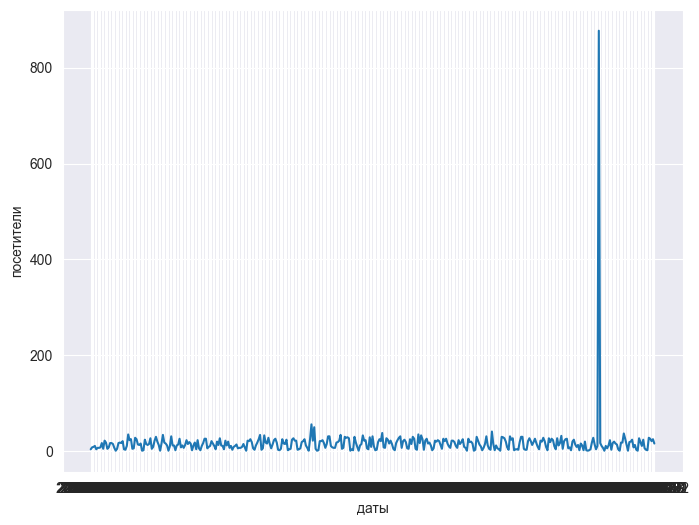

In [404]:
plt.figure(figsize=(8,6))
plt.plot(matching_times, matching_visitors)
plt.xlabel('даты')
plt.ylabel('посетители')
plt.show()

тут это очевидный выброс, поэтому это нужно удалить будет

In [391]:
#TODO вот отсюда продолжить
print(df.loc[maximum_visitors_cafe.air_store_id, ['visit_date', 'visitors', 'hpg_store_id']])

KeyError: "None of [Index(['air_cfdeb326418194ff'], dtype='object')] are in the [index]"

Text(0.5, 1.0, 'Ящик с усами для количества забронированных пользователей (без аномалий)')

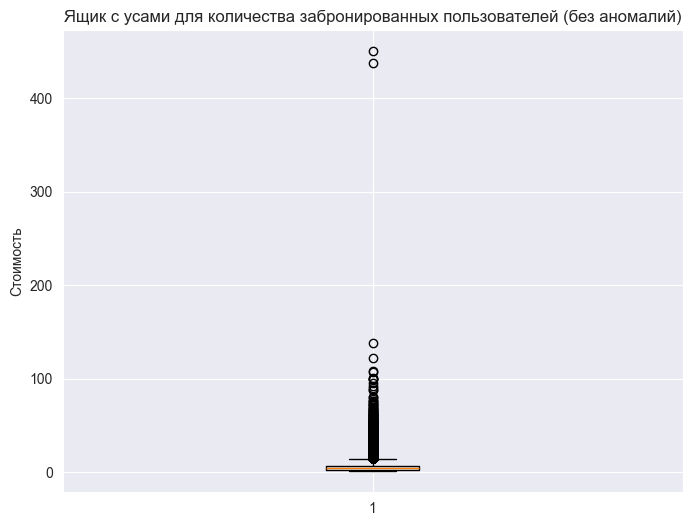

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(df_air_reserve['reserve_visitors'])
ax.set_ylabel('Стоимость')
ax.set_title('Ящик с усами для количества забронированных пользователей (без аномалий)')

In [110]:
df_air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      64320 non-null  object
 1   visit_date        64320 non-null  object
 2   reserve_date      64320 non-null  object
 3   reserve_visitors  64320 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.0+ MB


In [118]:
df_air_reserve.describe()

,reserve_visitors
count,61152.000000
mean,4.587667
std,3.355636
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,79.000000


In [53]:
df_air_reserve.shape

(83304, 4)

(67420, 4)

In [89]:
cols = df_air_reserve.columns
for col in cols:
    print(f"Характеристика: {col}")
    print("Количество уникальных значений:", {df_air_reserve[col].nunique()})
    print('///////////////////////////////////////////////////')

Характеристика: air_store_id
Количество уникальных значений: {314}
///////////////////////////////////////////////////
Характеристика: visit_date
Количество уникальных значений: {433}
///////////////////////////////////////////////////
Характеристика: reserve_date
Количество уникальных значений: {476}
///////////////////////////////////////////////////
Характеристика: reserve_visitors
Количество уникальных значений: {54}
///////////////////////////////////////////////////


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


(829, 5)

In [18]:
cols = df_air_store_info.columns
for col in cols:
    print(f"Характеристика: {col}")
    print("Количество уникальных значений:", {df_air_store_info[col].nunique()})
    print('///////////////////////////////////////////////////')

Характеристика: air_store_id
Количество уникальных значений: {829}
///////////////////////////////////////////////////
Характеристика: air_genre_name
Количество уникальных значений: {14}
///////////////////////////////////////////////////
Характеристика: air_area_name
Количество уникальных значений: {103}
///////////////////////////////////////////////////
Характеристика: latitude
Количество уникальных значений: {108}
///////////////////////////////////////////////////
Характеристика: longitude
Количество уникальных значений: {108}
///////////////////////////////////////////////////


In [ ]:
df_air_reserve = 